In [1]:
import cv2
import torch
import h5py
import numpy as np
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.methods.lstm import *
from sketch2code.methods.baseline1_supervised import *
from s02_supervise_baseline import *

/home/rook/.local/share/virtualenvs/sketch2code-rS5pvLAN/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Purpose

Supervised for program synthesis

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#examples 1750


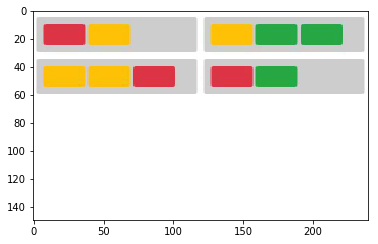

In [4]:
tags, images = load_dataset("toy")
print("#examples", len(tags))

def preprocess_img():
    global images
    return [shrink_img(img, 0.5).transpose((2, 0, 1)) for img in norm_rgb_imgs(images[:])]

images = cache_arrays("toy.shrink.imgs", preprocess_img)
plt.imshow(1 - images[0].transpose(1, 2, 0))
images = torch.tensor(images, device=device)

### Prepare datasets

In [85]:
vocab, ivocab = make_toy_vocab()

def get_datasets():
    train_examples = make_dataset(tags[:1250], vocab, 1)
    valid_examples = make_dataset(tags[1250:1500], vocab, 1)
    valid_examples = drop_examples(valid_examples, keep_prob=0.3)
    print("#valid examples", sum([len(x) for x in valid_examples]))
    test_examples = make_dataset(tags[1500:], vocab, 1)

    return train_examples, valid_examples, test_examples

train_examples, valid_examples, test_examples = cache_arrays("s02.toy.datasets", get_datasets, pickle=True)

### Define the model

In [87]:
class BLSuper1(nn.Module):
    
    def __init__(self, img_h: int, img_w: int, dsl_vocab: Dict[int, str], dsl_embedding_dim: int, dsl_hidden_dim: int):
        super().__init__()
        self.img_w = img_w
        self.img_h = img_h
        self.dsl_vocab = dsl_vocab
        self.dsl_hidden_dim = dsl_hidden_dim
        self.dsl_embedding_dim = dsl_embedding_dim

        self.__build_model()
    
    def __build_model(self):
        # network compute features of target image
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2)
        self.bn1 = nn.BatchNorm2d(16, momentum=0.9)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(32, momentum=0.9)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(64, momentum=0.9)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        imgsize = [self.img_h, self.img_w]
        for i, s in enumerate(imgsize):
            s = conv2d_size_out(s, 7, 2)
            s = pool2d_size_out(s, 3, 2)
            s = conv2d_size_out(s, 5, 1)
            s = pool2d_size_out(s, 3, 2)
            s = conv2d_size_out(s, 5, 1)
            s = pool2d_size_out(s, 3, 2)
            imgsize[i] = s
        
        linear_input_size = imgsize[0] * imgsize[1] * 64
        
        self.fc1 = nn.Linear(linear_input_size, 300)
        self.repr_size = 300
        
        # lstm that compute the context of the program
        self.lstm = LSTM(
            vocab_size=len(self.dsl_vocab),
            padding_token_idx=self.dsl_vocab['<pad>'],
            embedding_dim=self.dsl_embedding_dim,
            hidden_size=self.dsl_hidden_dim,
            n_layers=1)
        
        # network that combine the feature from lstm and cnn to predict the next token
        self.token_fc1 = nn.Linear(self.dsl_hidden_dim + self.repr_size, 200)
        self.token_fc2 = nn.Linear(200, len(self.dsl_vocab))

    def forward(self, x1, x2, x2_lens):
        """
            @x1: desired images (batch: N x C x W x H)
            @x2: current programs (batch: N x T)
            @x2_lens: lengths of current programs (N)
        """
        batch_size = x2_lens.shape[0]
        
        # STEP 1: compute output from CNN
        # X is N x C x W x H
        x1 = self.pool1(F.selu(self.conv1(x1)))
        x1 = self.pool2(F.selu(self.conv2(x1)))
        x1 = self.pool3(F.selu(self.conv3(x1)))
        
        # flatten to N x (C * W * H)
        x1 = x1.view(batch_size, -1)
        x1 = F.relu(self.fc1(x1))
    
        # STEP 2: compute feature from lstm
        x2, (hn, cn) = self.lstm(x2, x2_lens, self.lstm.init_hidden(x2, batch_size))
        # flatten from N x T x H to N x (T * H)
        hn = hn.view(batch_size, -1)
        
        # combine signal from CNN and LSTM to make decision
        xcom = torch.cat((x1, hn), 1)
        tokens = F.relu(self.token_fc1(xcom))
#         tokens = F.relu(self.token_fc2(tokens))
        tokens = self.token_fc2(tokens)
        tokens = F.log_softmax(tokens, dim=1)
        return tokens

In [ ]:
model = BLSuper1(img_h=150, img_w=240, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=200).to(device)
print(model.train())

loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

histories = train(model, loss_func, scheduler, optimizer, images, ([[e for ee in train_examples for e in ee]], valid_examples, test_examples), n_epoches=30, batch_size=100, device=device)

BLSuper1(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=300, bias=True)
  (lstm): LSTM(
    (word_embedding): Embedding(13, 100, padding_idx=0)
    (lstm): LSTM(100, 200, batch_first=True)
  )
  (token_fc1): Linear(in_features=500, out_features=200, bias=True)
  (token_fc2): Linear(in_featur

In [86]:
sum(len(x) for x in train_examples)

51402

In [10]:
sub_train_examples = drop_examples(train_examples, 0.2)

In [23]:
bimgs, bx, by, bxlen = next(iter_batch(100, images, sub_train_examples, shuffle=True, device=device))

In [77]:
model = BLSuper1(img_h=150, img_w=240, dsl_vocab=vocab, dsl_embedding_dim=100, dsl_hidden_dim=200).to(device)
print(model.train())

loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, amsgrad=True)

BLSuper1(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=300, bias=True)
  (lstm): LSTM(
    (word_embedding): Embedding(13, 100, padding_idx=0)
    (lstm): LSTM(100, 200, batch_first=True)
  )
  (token_fc1): Linear(in_features=500, out_features=200, bias=True)
  (token_fc2): Linear(in_featur

In [80]:
model.zero_grad()
bypred = model(bimgs, bx, bxlen)
print(bypred)
loss = loss_func(bypred, by)
print(loss)
loss.backward()
optimizer.step()

tensor([[-167.0796,    0.0000, -178.6150,  ..., -163.9495, -165.9761,
         -152.4479],
        [-233.9970,    0.0000, -250.2912,  ..., -229.8179, -232.6823,
         -213.6809],
        [-106.4276,    0.0000, -113.9810,  ..., -104.5811, -105.8515,
          -97.1870],
        ...,
        [-101.3715,    0.0000, -108.5300,  ...,  -99.5635, -100.8307,
          -92.5244],
        [-103.5791,    0.0000, -110.8879,  ..., -101.7301, -103.0167,
          -94.5524],
        [-161.0129,    0.0000, -172.1727,  ..., -158.0798, -160.0067,
         -146.9172]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


In [42]:
loss = loss_func(bypred, by)

In [43]:
loss

tensor(2.5650, device='cuda:0', grad_fn=<NllLossBackward>)

In [44]:
loss.backward()

In [45]:
optimizer.step()

In [55]:
optimizer.__dict__

{'defaults': {'lr': 0.005,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': True},
 'state': defaultdict(dict, {Parameter containing:
              tensor([[[[-6.3491e-02, -5.8604e-02,  2.8488e-02,  ...,  6.6019e-02,
                         -6.3953e-02,  2.8382e-02],
                        [-1.8606e-02,  6.5816e-02, -5.9203e-03,  ..., -4.3892e-02,
                         -7.1090e-02,  8.5385e-02],
                        [ 5.2127e-02,  2.7345e-02,  4.7772e-02,  ..., -4.1387e-02,
                          5.9417e-03,  4.9544e-02],
                        ...,
                        [ 2.3725e-03, -5.8031e-02,  2.3913e-02,  ..., -6.7629e-02,
                          5.6124e-02, -6.0854e-02],
                        [ 1.5982e-02,  3.1966e-02, -1.4204e-02,  ...,  5.5727e-02,
                         -6.3696e-02,  1.4992e-03],
                        [ 7.3167e-02,  3.4742e-02,  8.4302e-02,  ...,  6.1485e-02,
                          5.5011e-02, -2.7177e-04]],
